## 0.0 Setup

In [1]:
# Import data and libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.ensemble import RUSBoostClassifier

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import lime
import lime.lime_tabular
import shap

data = pd.read_csv('term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## 0.1 Preprocessing

In [2]:
# List of columns labels.

column_labels = list(data.columns)

# Unique values in each column.
for label in column_labels:
    print(f'{label}: {data[label].unique()}\n')

age: [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]

job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital: ['married' 'single' 'divorced']

education: ['tertiary' 'secondary' 'unknown' 'primary']

default: ['no' 'yes']

balance: [  2143     29      2 ...   7222   3402 102127]

housing: ['yes' 'no']

loan: ['no' 'yes']

contact: ['unknown' 'cellular' 'telephone']

day: [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']

duration: [ 261  151   76 ... 1880 1460 2219]

campaign: [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 

In [3]:
# Value counts for each column.
for label in column_labels:
    print(f'{label}: {data[label].value_counts()}\n')

age: 32    1909
31    1826
33    1770
34    1730
35    1721
      ... 
94       1
81       1
90       1
86       1
95       1
Name: age, Length: 70, dtype: int64

job: blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

marital: married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

education: secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

default: no     39191
yes      809
Name: default, dtype: int64

balance: 0        3209
1         179
2         141
4         126
3         124
         ... 
11686       1
7602        1
3536        1
7634        1
3630        1
Name: balance, Length: 6849, dtype: int64

housing: yes    24031
no     15969
Name: housing, dtype: int64


In [4]:
# Remove contact column.
# 

# Replace yes/no with 1/0.

data.replace(to_replace={'yes': 1, 'no': 0}, inplace=True)

# Replacce month names with numbers.

months = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}
data.replace(to_replace=months, inplace=True)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,5,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,5,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,5,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,5,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,5,198,1,0


In [5]:
# Convert categorical variables to dummy variables.

data_dummies = pd.get_dummies(data, columns=['job', 'marital'])
data_dummies.head()

,age,education,default,balance,housing,loan,contact,day,month,duration,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,tertiary,0,2143,1,0,unknown,5,5,261,...,0,0,0,0,0,0,0,0,1,0
1,44,secondary,0,29,1,0,unknown,5,5,151,...,0,0,0,0,1,0,0,0,0,1
2,33,secondary,0,2,1,1,unknown,5,5,76,...,0,0,0,0,0,0,0,0,1,0
3,47,unknown,0,1506,1,0,unknown,5,5,92,...,0,0,0,0,0,0,0,0,1,0
4,33,unknown,0,1,0,0,unknown,5,5,198,...,0,0,0,0,0,0,1,0,0,1


In [6]:
# Remove contact variable (too many unknowns)

data_dummies.drop(columns='contact', inplace=True)
data_dummies.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,tertiary,0,2143,1,0,5,5,261,1,...,0,0,0,0,0,0,0,0,1,0
1,44,secondary,0,29,1,0,5,5,151,1,...,0,0,0,0,1,0,0,0,0,1
2,33,secondary,0,2,1,1,5,5,76,1,...,0,0,0,0,0,0,0,0,1,0
3,47,unknown,0,1506,1,0,5,5,92,1,...,0,0,0,0,0,0,0,0,1,0
4,33,unknown,0,1,0,0,5,5,198,1,...,0,0,0,0,0,0,1,0,0,1


In [7]:
# Replace education values with numbers.

edu = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
data_dummies.replace(to_replace=edu, inplace=True)
data_dummies.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,3,0,2143,1,0,5,5,261,1,...,0,0,0,0,0,0,0,0,1,0
1,44,2,0,29,1,0,5,5,151,1,...,0,0,0,0,1,0,0,0,0,1
2,33,2,0,2,1,1,5,5,76,1,...,0,0,0,0,0,0,0,0,1,0
3,47,0,0,1506,1,0,5,5,92,1,...,0,0,0,0,0,0,0,0,1,0
4,33,0,0,1,0,0,5,5,198,1,...,0,0,0,0,0,0,1,0,0,1


In [8]:
data = data_dummies

## 1.0 Exploratory Data Analysis

In [9]:
# Get X and y columns.

X_labels = list(data.columns)
X_labels.remove('y')
X = data[X_labels]
y = data['y']

In [10]:
# Correlation

corr_matrix = X.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.33)]
print(to_drop)

['job_management', 'job_retired']


In [11]:
# Drop values

to_drop.append('y')
X_corr = data.drop(columns=to_drop)
X_corr

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,job_housemaid,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,3,0,2143,1,0,5,5,261,1,...,0,0,0,0,0,0,0,0,1,0
1,44,2,0,29,1,0,5,5,151,1,...,0,0,0,0,1,0,0,0,0,1
2,33,2,0,2,1,1,5,5,76,1,...,0,0,0,0,0,0,0,0,1,0
3,47,0,0,1506,1,0,5,5,92,1,...,0,0,0,0,0,0,0,0,1,0
4,33,0,0,1,0,0,5,5,198,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,3,0,395,0,0,3,6,107,1,...,0,0,0,0,1,0,0,0,1,0
39996,30,3,0,3340,0,0,3,6,238,3,...,0,0,0,0,0,0,0,0,0,1
39997,54,2,0,200,0,0,3,6,170,1,...,0,0,0,0,0,0,0,1,0,0
39998,34,3,0,1047,0,0,3,6,342,1,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# ANOVA F Value

fvalue_selector = SelectKBest(f_classif, k=12)

X_kbest = fvalue_selector.fit_transform(X, y)

X_kbest

array([[   3, 2143,    1, ...,    0,    1,    0],
       [   2,   29,    1, ...,    0,    0,    1],
       [   2,    2,    1, ...,    0,    1,    0],
       ...,
       [   2,  200,    0, ...,    0,    0,    0],
       [   3, 1047,    0, ...,    0,    1,    0],
       [   2, 1442,    1, ...,    0,    1,    0]], dtype=int64)

In [13]:
# Get kbest labels.

column_labels = list(data.columns)
kbest_labels = []
for label in column_labels:
    for i in range(12):
        if sum(list(X_kbest[:,i] == data[label])) == 40000:
            kbest_labels.append(label)
            
print(kbest_labels)

['education', 'balance', 'housing', 'loan', 'month', 'duration', 'campaign', 'job_blue-collar', 'job_retired', 'job_student', 'marital_married', 'marital_single']


In [14]:
# Keep X_kbest

X_kbest = pd.DataFrame(data=X_kbest, columns=kbest_labels)
X_kbest.head()

,education,balance,housing,loan,month,duration,campaign,job_blue-collar,job_retired,job_student,marital_married,marital_single
0,3,2143,1,0,5,261,1,0,0,0,1,0
1,2,29,1,0,5,151,1,0,0,0,0,1
2,2,2,1,1,5,76,1,0,0,0,1,0
3,0,1506,1,0,5,92,1,1,0,0,1,0
4,0,1,0,0,5,198,1,0,0,0,0,1


## 1.1 Sampling Selection

In [15]:
# Acquire splits.
kf = KFold(n_splits=5, shuffle=True, random_state=1)
splits = kf.split(X, y)

for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_train, y_train)

       age  education  default  balance  housing  loan  day  month  duration  \
0       58          3        0     2143        1     0    5      5       261   
1       44          2        0       29        1     0    5      5       151   
2       33          2        0        2        1     1    5      5        76   
3       47          0        0     1506        1     0    5      5        92   
4       33          0        0        1        0     0    5      5       198   
...    ...        ...      ...      ...      ...   ...  ...    ...       ...   
39994   35          3        0     3109        1     0    3      6       467   
39995   53          3        0      395        0     0    3      6       107   
39996   30          3        0     3340        0     0    3      6       238   
39997   54          2        0      200        0     0    3      6       170   
39999   38          2        0     1442        1     0    3      6       113   

       campaign  ...  job_retired  job_

0    29712
1    29712
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7392
           1       0.40      0.75      0.53       608

    accuracy                           0.90      8000
   macro avg       0.69      0.83      0.73      8000
weighted avg       0.93      0.90      0.91      8000



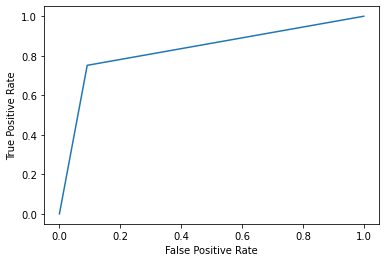

AUC: 0.8301649008885852


In [16]:
# Random Oversampler
ros = RandomOverSampler(random_state=1)

def sampler_metrics(resampler):
    X_train_rs, y_train_rs = resampler.fit_resample(X_train, y_train)

    # Check value counts.
    print(y_train_rs.value_counts())
    
    xgb = XGBClassifier()
    xgb.fit(X_train_rs, y_train_rs)
    y_pred = xgb.predict(X_test)

    report = metrics.classification_report(y_test, y_pred)
    print('')
    print(report)

    # ROC and AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    AUC = metrics.roc_auc_score(y_test, y_pred)
    print(f'AUC: {AUC}')
    
sampler_metrics(ros)

0    2288
1    2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7392
           1       0.33      0.88      0.48       608

    accuracy                           0.86      8000
   macro avg       0.66      0.87      0.70      8000
weighted avg       0.94      0.86      0.88      8000



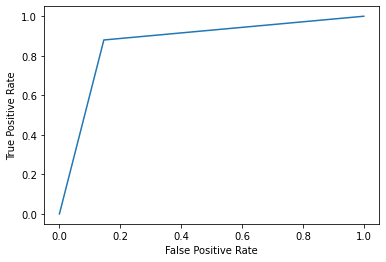

AUC: 0.8669827979038506


In [17]:
# Random Undersampler
rus = RandomUnderSampler(random_state=1)
sampler_metrics(rus)

0    2288
1    2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.94      0.06      0.12      7392
           1       0.08      0.95      0.14       608

    accuracy                           0.13      8000
   macro avg       0.51      0.51      0.13      8000
weighted avg       0.87      0.13      0.12      8000



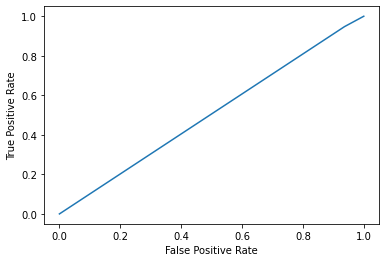

AUC: 0.5054076953748006


In [18]:
# Cluster Centroids
cc = ClusterCentroids(random_state=1)
sampler_metrics(cc)

Version 1
0    2288
1    2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.99      0.45      0.62      7392
           1       0.12      0.93      0.21       608

    accuracy                           0.48      8000
   macro avg       0.55      0.69      0.42      8000
weighted avg       0.92      0.48      0.59      8000



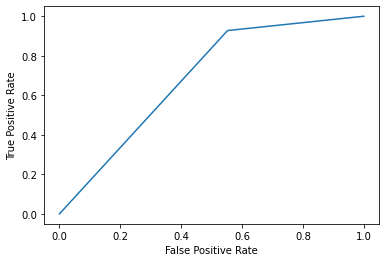

AUC: 0.6875712007290955

Version 2
0    2288
1    2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.94      0.08      0.15      7392
           1       0.08      0.94      0.14       608

    accuracy                           0.15      8000
   macro avg       0.51      0.51      0.15      8000
weighted avg       0.88      0.15      0.15      8000



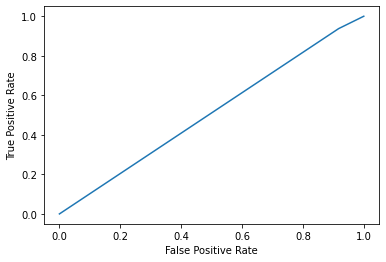

AUC: 0.5100108225108225

Version 3
0    2288
1    2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.99      0.45      0.62      7392
           1       0.12      0.93      0.21       608

    accuracy                           0.48      8000
   macro avg       0.55      0.69      0.42      8000
weighted avg       0.92      0.48      0.59      8000



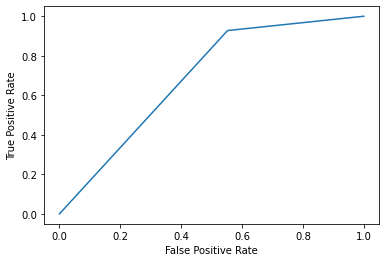

AUC: 0.6875712007290955


In [19]:
# Near Miss
print('Version 1')
nm1 = NearMiss(version=1)
sampler_metrics(nm1)

print('\nVersion 2')
nm2 = NearMiss(version=2)
sampler_metrics(nm2)

print('\nVersion 3')
nm3 = NearMiss(version=3)
sampler_metrics(nm1)

All
0    26234
1     2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      7392
           1       0.48      0.63      0.54       608

    accuracy                           0.92      8000
   macro avg       0.72      0.79      0.75      8000
weighted avg       0.93      0.92      0.92      8000



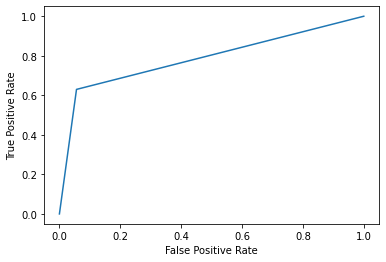

AUC: 0.7868962178172706

Mode
0    28932
1     2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7392
           1       0.52      0.49      0.50       608

    accuracy                           0.93      8000
   macro avg       0.74      0.73      0.73      8000
weighted avg       0.92      0.93      0.93      8000



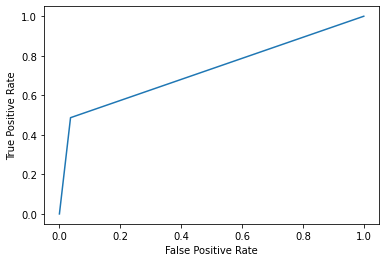

AUC: 0.725158065618592


In [20]:
# Edited Nearest Neighbour
print('All')
enn_a = EditedNearestNeighbours(kind_sel='all')
sampler_metrics(enn_a)

print('\nMode')
enn_m = EditedNearestNeighbours(kind_sel='mode')
sampler_metrics(enn_m)

0    25062
1     2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7392
           1       0.44      0.71      0.55       608

    accuracy                           0.91      8000
   macro avg       0.71      0.82      0.75      8000
weighted avg       0.93      0.91      0.92      8000



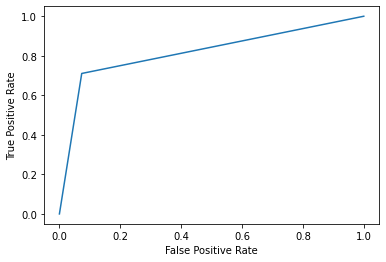

AUC: 0.8186019024834814


In [21]:
# Repeated Edited Nearest Neighbours
renn = RepeatedEditedNearestNeighbours()
sampler_metrics(renn)

0    25619
1     2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      7392
           1       0.47      0.68      0.55       608

    accuracy                           0.92      8000
   macro avg       0.72      0.81      0.75      8000
weighted avg       0.93      0.92      0.92      8000



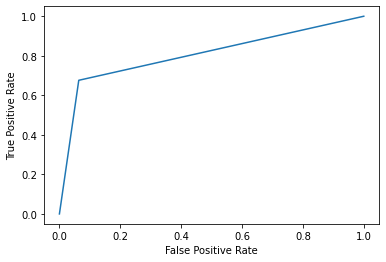

AUC: 0.8062022955115061


In [22]:
# AllKNN
allknn = AllKNN()
sampler_metrics(allknn)

0    28814
1     2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7392
           1       0.56      0.43      0.48       608

    accuracy                           0.93      8000
   macro avg       0.76      0.70      0.72      8000
weighted avg       0.92      0.93      0.93      8000



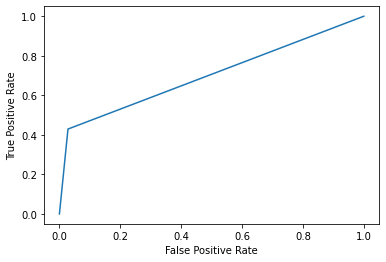

AUC: 0.7005688938254727


In [23]:
# One Sided Selection
oss = OneSidedSelection(random_state=1)
sampler_metrics(oss)

0    25973
1     2288
Name: y, dtype: int64

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7392
           1       0.48      0.62      0.54       608

    accuracy                           0.92      8000
   macro avg       0.73      0.78      0.75      8000
weighted avg       0.93      0.92      0.93      8000



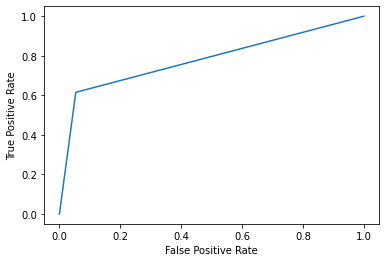

AUC: 0.7806447938026887


In [24]:
# Neighbourhood Cleaning Rule
ncr = NeighbourhoodCleaningRule()
sampler_metrics(ncr)


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7392
           1       0.28      0.81      0.42       608

    accuracy                           0.83      8000
   macro avg       0.63      0.82      0.66      8000
weighted avg       0.93      0.83      0.86      8000



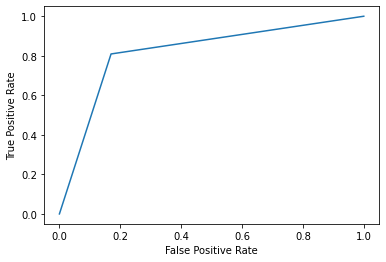

AUC: 0.8197838345864661


In [25]:
# RUS Boost Classifier

rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R', random_state=1)
rusboost.fit(X_train, y_train)
y_pred = rusboost.predict(X_test)

report = metrics.classification_report(y_test, y_pred)
print('')
print(report)

# ROC and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

AUC = metrics.roc_auc_score(y_test, y_pred)
print(f'AUC: {AUC}')

In [26]:
# Highest AUC: Random Undersampler
# Highest Class 1 F1 Score: Neighbourhood Cleaning Rule

## 1.2 Variable Set Selection
### 1.2.1 RUS

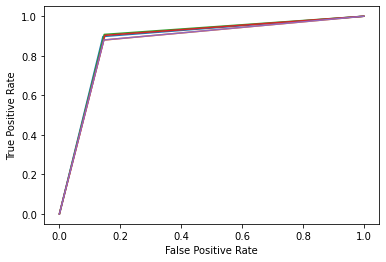

F1 (0,1): (0.9169733144319373, 0.4741944717700754)
AUC: 0.873667936829339


In [27]:
# XGBoost (all columns)

rus = RandomUnderSampler(random_state=1)

def get_xgb_scores(X, y, resampler):
    xgb = XGBClassifier()
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    splits = kf.split(X, y)
    f1_scores_0 = []
    f1_scores_1 = []
    AUC_scores = []
    for train_index, test_index in splits:
        # Get splits
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Oversample
        X_train_rs, y_train_rs = resampler.fit_resample(X_train, y_train)
    
        # Fit model and predict
        xgb.fit(X_train_rs, y_train_rs)
        y_pred = xgb.predict(X_test)
    
        # Acquire metrics report
        report = metrics.classification_report(y_test, y_pred, output_dict=True)
        f1_scores_0.append(report['0']['f1-score'])
        f1_scores_1.append(report['1']['f1-score'])
    
        # Plot ROC and get AUC Scores
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr)
        AUC_scores.append(metrics.roc_auc_score(y_test, y_pred))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    return f1_scores_0, f1_scores_1, AUC_scores

f1_scores_0, f1_scores_1, AUC_scores = get_xgb_scores(X=X, y=y, resampler=rus)
av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

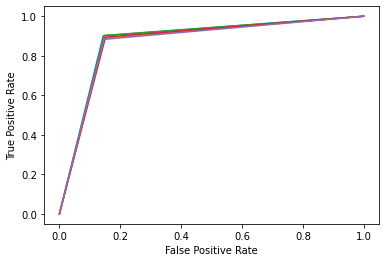

F1 (0,1): (0.9163594868964641, 0.47264540501203867)
AUC: 0.8733315706398143


In [28]:
#  XGBoost (Correlation)

f1_scores_0, f1_scores_1, AUC_scores = get_xgb_scores(X=X_corr, y=y, resampler=rus)
av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

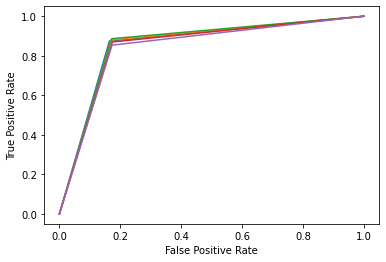

F1 (0,1): (0.9019314339673719, 0.43018451257136814)
AUC: 0.8511465325221168


In [29]:
# XGBoost (F score)

f1_scores_0, f1_scores_1, AUC_scores = get_xgb_scores(X=X_kbest, y=y, resampler=rus)
av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

### 1.2.2 NCR

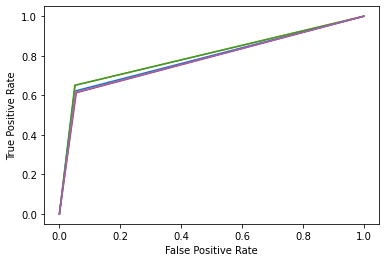

F1 (0,1): (0.9588993088344138, 0.5476597067616658)
AUC: 0.7889474162956727


In [30]:
# XGBoost (all columns)
ncr = NeighbourhoodCleaningRule()

f1_scores_0, f1_scores_1, AUC_scores = get_xgb_scores(X=X, y=y, resampler=ncr)
av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

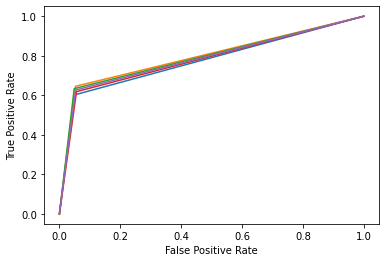

F1 (0,1): (0.9589149253936281, 0.5456881627833093)
AUC: 0.7866567734523147


In [31]:
# XGBoost (correlation)
f1_scores_0, f1_scores_1, AUC_scores = get_xgb_scores(X=X_corr, y=y, resampler=ncr)
av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

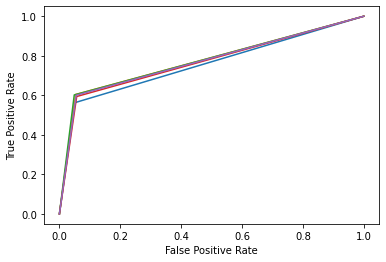

F1 (0,1): (0.9571624777617018, 0.5217639304006979)
AUC: 0.7698581950827401


In [32]:
# XGBoost (keep by F value)
f1_scores_0, f1_scores_1, AUC_scores = get_xgb_scores(X=X_kbest, y=y, resampler=ncr)
av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

## 2.0 HP Optimization
### 2.0.1 RUS

In [33]:
# HP Opt
space = {'eta': hp.uniform('eta', 0, 1),
         'gamma': hp.uniform('gamma', 0, 10),
         'max_depth': hp.quniform('max_depth', 1, 20, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'seed': 0}

def objective(space):
    clf=XGBClassifier(eta=space['eta'],
                      gamma=space['gamma'],
                      max_depth=int(space['max_depth']),
                      min_child_weight=int(space['min_child_weight'])
                     )
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    splits = kf.split(X, y)
    
    scores = []
    for train_index, test_index in splits:
        # Get splits
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Resample
        X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
    
        # Fit model and predict
        clf.fit(X_train_us, y_train_us)
        y_pred = clf.predict(X_test)
    
        # Acquire metrics report
        scores.append(metrics.roc_auc_score(y_test, y_pred))
    auc = np.mean(scores)
        
    print(f'Score: {auc}')
    return {'loss':-auc, 'status': STATUS_OK}

In [34]:
trials = Trials()

opt = fmin(fn=objective, 
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

Score: 0.863638075808694                               
Score: 0.8774252752427516                                                        
Score: 0.8670546520402007                                                         
Score: 0.869685746613268                                                          
Score: 0.8762957563971014                                                         
Score: 0.8717715829890423                                                         
Score: 0.8698387101275287                                                         
Score: 0.8640258939474551                                                         
Score: 0.8612062068526528                                                         
Score: 0.8662853680646447                                                         
Score: 0.8663003393704827                                                          
Score: 0.8677153352814321                                                          
Score: 0.8791047793464882     

In [35]:
print(opt)

{'eta': 0.16561326980303542, 'gamma': 3.192700087353282, 'max_depth': 20.0, 'min_child_weight': 2.0}


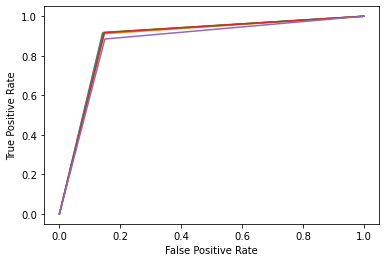

F1 (0,1): (0.9175846208753404, 0.4806127055196476)
AUC: 0.8815909178626258


In [36]:
xgb_opt = XGBClassifier(eta=opt['eta'], 
                        gamma=opt['gamma'],
                        max_depth=int(opt['max_depth']),
                        min_child_weight=int(opt['min_child_weight'])
                       )
rus = RandomUnderSampler(random_state=1)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
splits = kf.split(X, y)

f1_scores_0 = []
f1_scores_1 = []
AUC_scores = []
for train_index, test_index in splits:
    # Get splits
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Resample
    X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
    
    # Fit model and predict
    xgb_opt.fit(X_train_us, y_train_us)
    y_pred = xgb_opt.predict(X_test)
    
    # Acquire metrics report
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    f1_scores_0.append(report['0']['f1-score'])
    f1_scores_1.append(report['1']['f1-score'])
    
    # Plot ROC and get AUC Scores
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    AUC_scores.append(metrics.roc_auc_score(y_test, y_pred))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

### 2.0.2 NCR

In [37]:
# HP Opt
space = {'eta': hp.uniform('eta', 0, 1),
         'gamma': hp.uniform('gamma', 0, 10),
         'max_depth': hp.quniform('max_depth', 1, 20, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'seed': 0}

def objective(space):
    clf=XGBClassifier(eta=space['eta'],
                      gamma=space['gamma'],
                      max_depth=int(space['max_depth']),
                      min_child_weight=int(space['min_child_weight'])
                     )
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    splits = kf.split(X, y)
    
    scores = []
    for train_index, test_index in splits:
        # Get splits
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Resample
        X_train_mcr, y_train_ncr = ncr.fit_resample(X_train, y_train)
    
        # Fit model and predict
        clf.fit(X_train_us, y_train_us)
        y_pred = clf.predict(X_test)
    
        # Acquire metrics report
        scores.append(metrics.roc_auc_score(y_test, y_pred))
    auc = np.mean(scores)
        
    print(f'Score: {auc}')
    return {'loss':-auc, 'status': STATUS_OK}

In [38]:
trials = Trials()

opt = fmin(fn=objective, 
           space=space,
           algo=tpe.suggest,
           max_evals=10,
           trials=trials)

Score: 0.8928535393146371                             
Score: 0.8657168479916846                                                         
Score: 0.8765332180100665                                                         
Score: 0.8922985782130818                                                         
Score: 0.8679194128303573                                                         
Score: 0.8701782497561256                                                         
Score: 0.8986027708610751                                                         
Score: 0.79986211747922                                                           
Score: 0.8879969751426305                                                         
Score: 0.8958727253411187                                                         
100%|██████████| 10/10 [18:13<00:00, 109.36s/trial, best loss: -0.8986027708610751]


In [39]:
print(opt)

{'eta': 0.9371566425398791, 'gamma': 2.331694747302678, 'max_depth': 8.0, 'min_child_weight': 4.0}


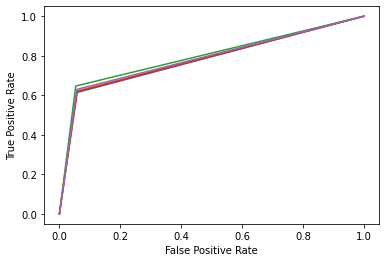

F1 (0,1): (0.9564656194858081, 0.5323096586313294)
AUC: 0.7848528772363306


In [40]:
xgb_opt = XGBClassifier(eta=opt['eta'], 
                        gamma=opt['gamma'],
                        max_depth=int(opt['max_depth']),
                        min_child_weight=int(opt['min_child_weight'])
                       )
ncr = NeighbourhoodCleaningRule()
kf = KFold(n_splits=5, shuffle=True, random_state=1)
splits = kf.split(X, y)

f1_scores_0 = []
f1_scores_1 = []
AUC_scores = []
for train_index, test_index in splits:
    # Get splits
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Resample
    X_train_ncr, y_train_ncr = ncr.fit_resample(X_train, y_train)
    
    # Fit model and predict
    xgb_opt.fit(X_train_ncr, y_train_ncr)
    y_pred = xgb_opt.predict(X_test)
    
    # Acquire metrics report
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    f1_scores_0.append(report['0']['f1-score'])
    f1_scores_1.append(report['1']['f1-score'])
    
    # Plot ROC and get AUC Scores
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    AUC_scores.append(metrics.roc_auc_score(y_test, y_pred))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

av_f1_scores = (np.mean(f1_scores_0), np.mean(f1_scores_1))
av_AUC_score = np.mean(AUC_scores)
print(f'F1 (0,1): {av_f1_scores}')
print(f'AUC: {av_AUC_score}')

## 3.0 Model Explanation

In [41]:
# Fit model

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
ncr = NeighbourhoodCleaningRule()
X_train_ncr, y_train_ncr = ncr.fit_resample(X_train, y_train)
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.9371566425398791, eval_metric=None, gamma=2.331694747302678,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.937156618,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=8,
              max_leaves=0, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [42]:
# Get shap values
exp = shap.TreeExplainer(xgb_opt)
shap_values_test = exp.shap_values(X_test)
shap_values_train = exp.shap_values(X_train_ncr)

df_shap_test = pd.DataFrame(shap_values_test, columns=X_test.columns.values)
df_shap_train = pd.DataFrame(shap_values_train, columns=X_train_ncr.columns.values)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [43]:
#Initialize
j = 0
shap.initjs

categorical_features = np.argwhere(np.array([len(set(X_train_ncr.values[:,x]))
for x in range(X_train_ncr.values.shape[1])]) <= 10).flatten()

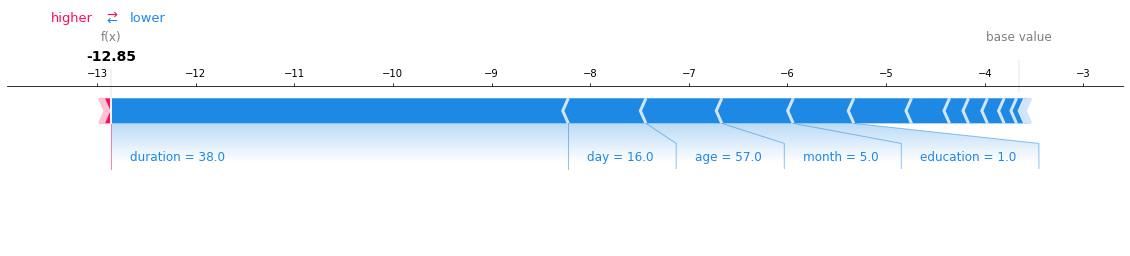

In [44]:
shap.force_plot(exp.expected_value, shap_values_test[j], X_test.iloc[[j]], matplotlib=True)

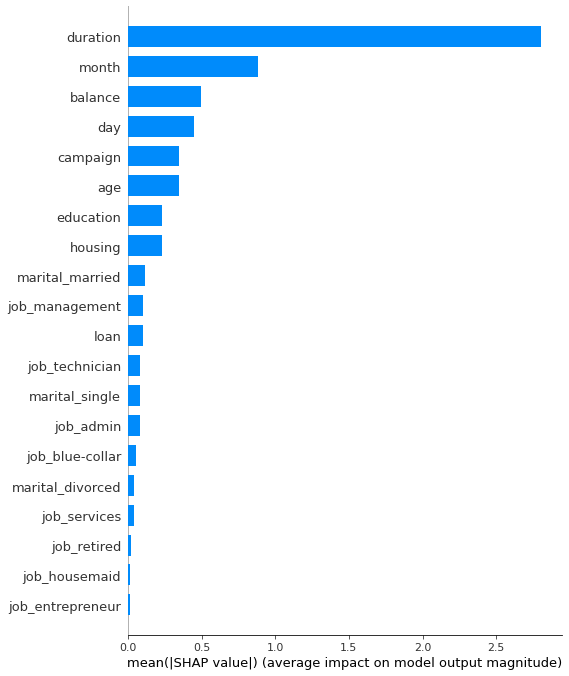

In [45]:
shap.summary_plot(shap_values_train, X_train_ncr, plot_type='bar')

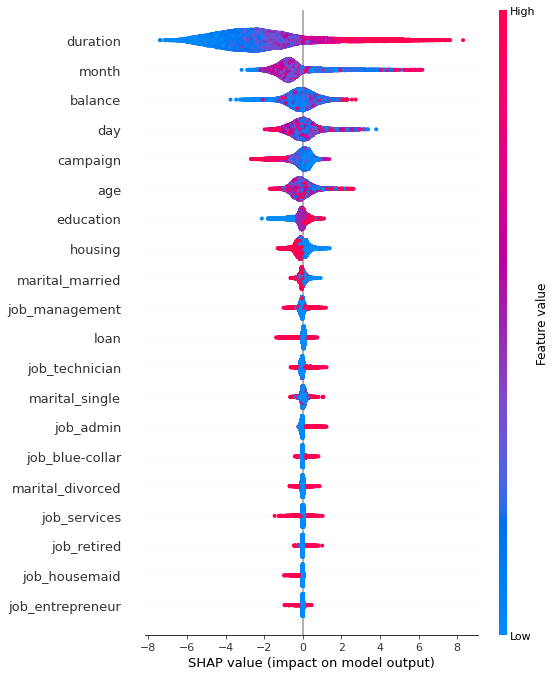

In [46]:
shap.summary_plot(shap_values_train, X_train_ncr)

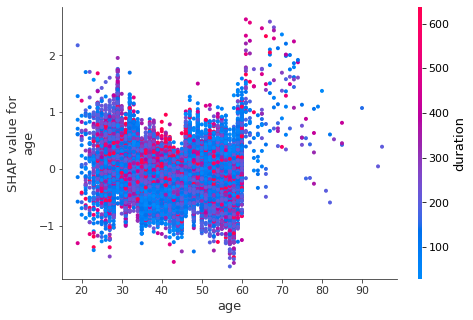

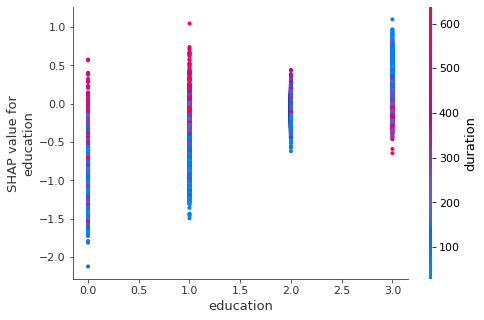

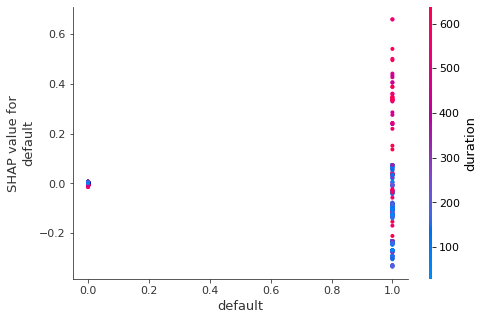

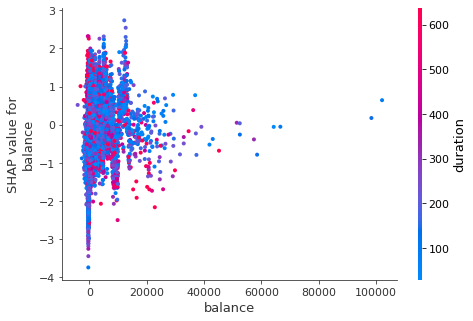

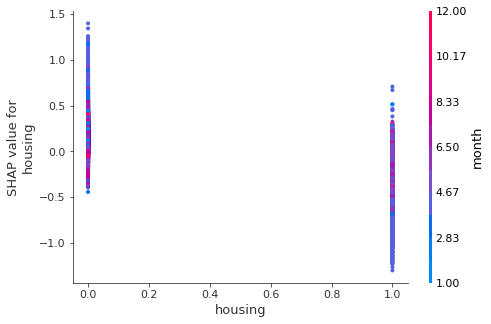

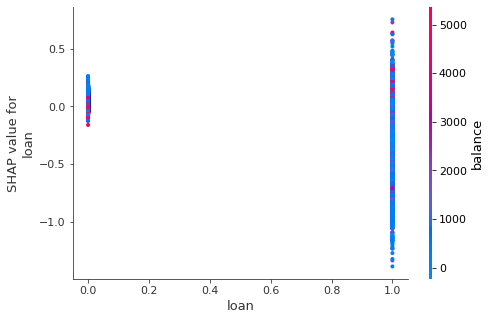

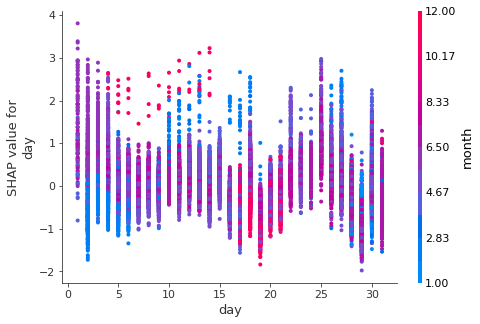

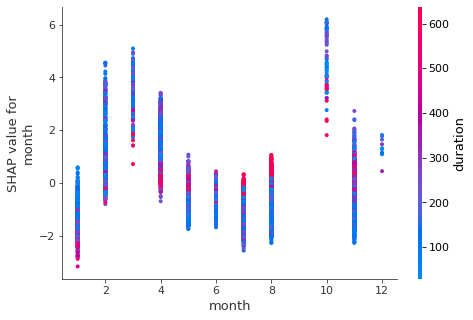

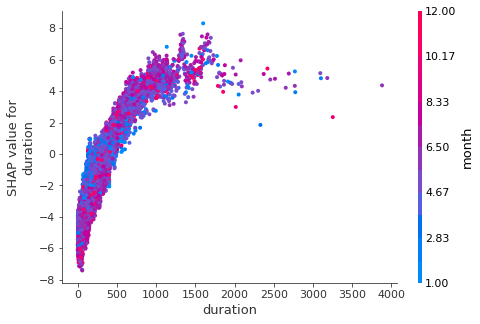

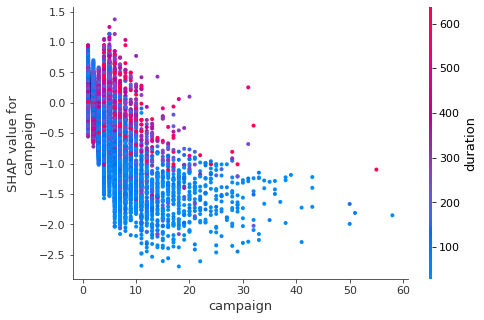

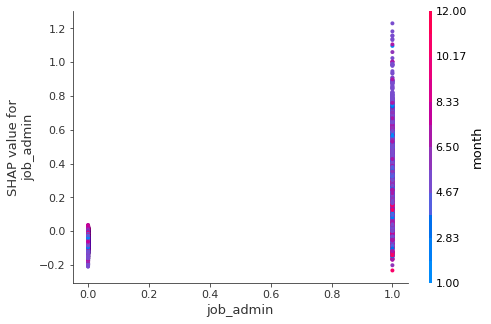

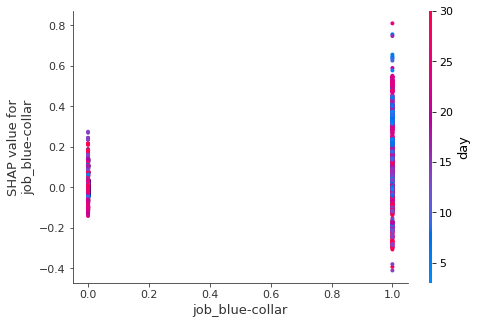

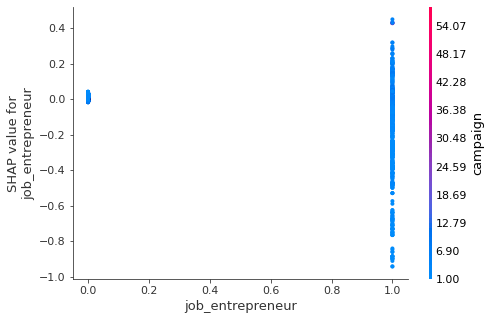

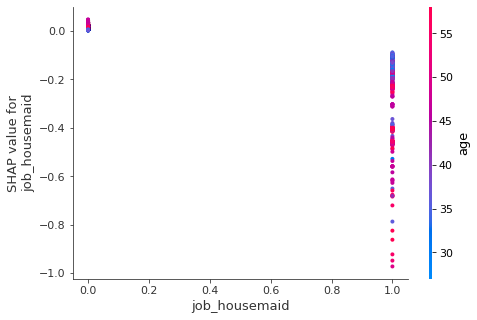

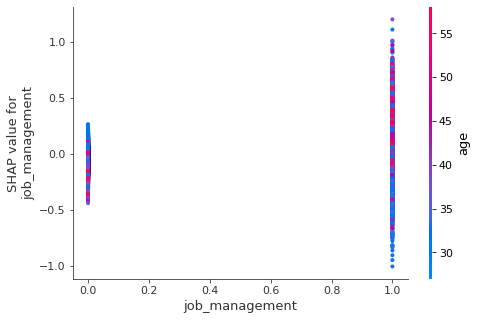

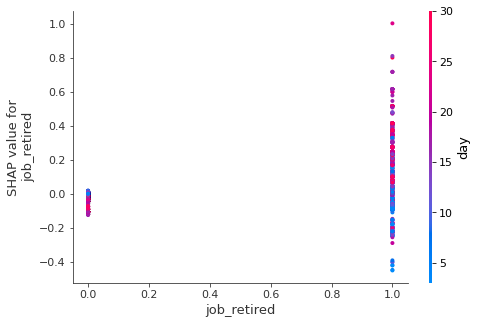

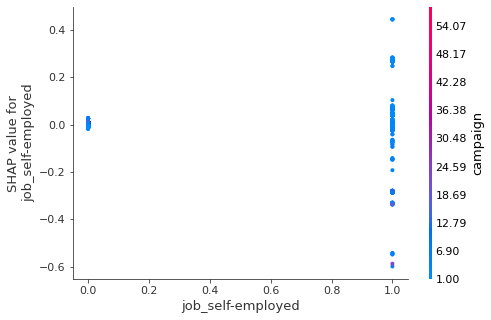

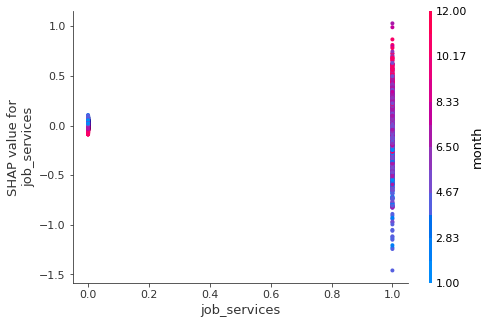

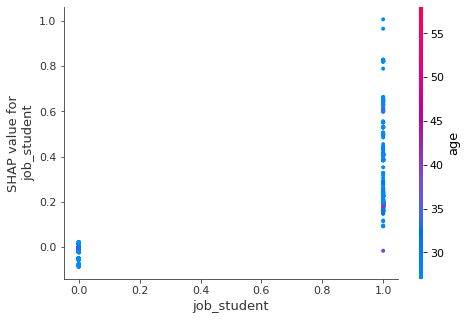

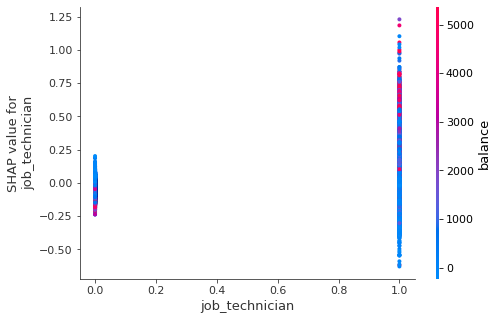

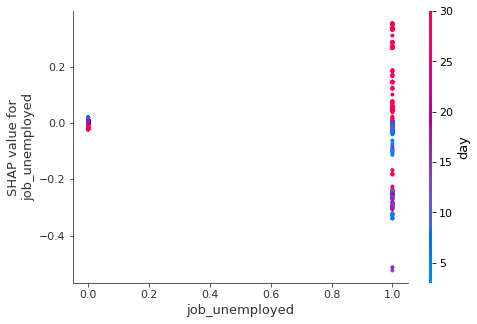

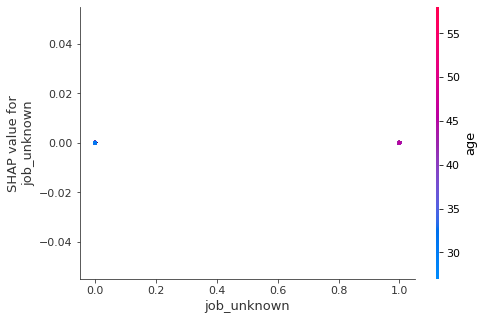

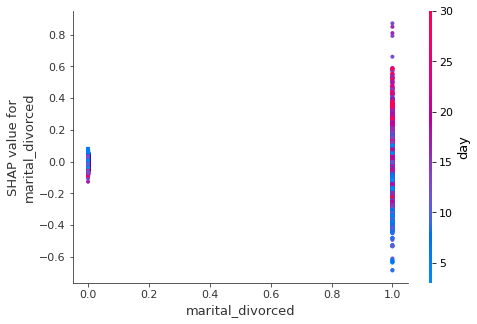

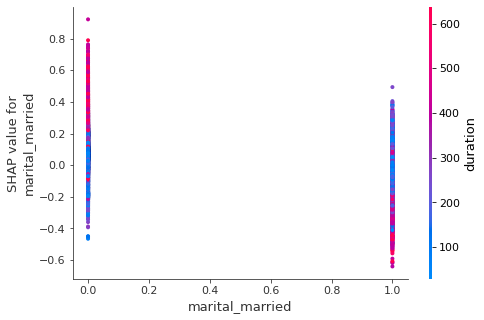

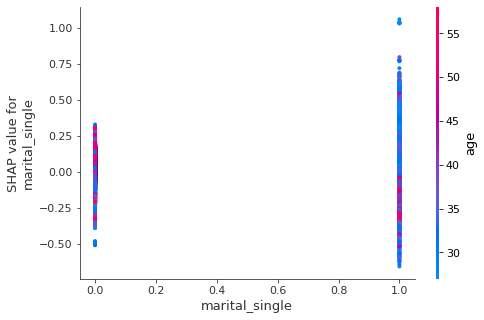

In [47]:
if 'y' in column_labels:
    column_labels.remove('y')
    
for label in column_labels:
    shp_plt = shap.dependence_plot(label, shap_values_train, X_train_ncr)